# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [3]:
!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

import pandas as pd
import numpy as np
import os

model = spacy.load("en_core_web_sm")

ModuleNotFoundError: No module named 'spacy'

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**



In [ ]:
# Function to convert  
def listToString(s): 
    # initialize an empty string
    str1 = "" 
    # traverse in the string  
    for ele in s:
        str1 += ele  
    
    return str1 


In [ ]:
   train_sentence= [] 
def ConstructSentences(filename,list_of_sentence):
    with open(filename, 'r') as train_sent_file:
        train_words = train_sent_file.readlines()
       
    list_of_sentence.clear()
    train_sentence.clear()
    
    for word in train_words:
      if(word!='\n'):
         word = word.replace('\n',' ')
         train_sentence.append(word)
      else:
        str2 =listToString(train_sentence)
        #print(str2)
        list_of_sentence.append(str2)
        train_sentence.clear()   
    

### Count the number of sentences in the processed train and test dataset 

In [ ]:
list_of_train_sent =[]
ConstructSentences("train_sent",list_of_train_sent)
print("Sentences in Processed Train :",len(list_of_train_sent))

list_of_test_sent =[]
ConstructSentences("test_sent",list_of_test_sent)
print("Sentences in Test dataset",len(list_of_test_sent))

### Count the number of lines of labels in the processed train and test dataset.

In [ ]:
list_of_train_label =[]
ConstructSentences("train_label",list_of_train_label)
print("Number of lines of labels in the processed train:",len(list_of_train_label))

list_of_test_label =[]
ConstructSentences("test_label",list_of_test_label)
print("Number of lines of labels in the Test dataset:",len(list_of_test_label))

### Print 5 sentences

In [ ]:
for i in range(0,5):
    print(list_of_train_sent[i])
    print(list_of_train_label[i])
    #print(i )

In [ ]:
# print five sentences in test dataset along with their labels.
for i in range(0,5):
    print(list_of_test_sent[i])
    print(list_of_test_label[i])

##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [ ]:
pos = []
lemma = []
text = []
for sentence in list_of_train_sent:
    review1=model(sentence)
    for tok in review1:
         if tok.pos_=="NOUN" or tok.pos_=="PROPN":
            pos.append(tok.pos_)
            lemma.append(tok.lemma_.lower())
            text.append(tok.text)
        #print(tok.text,"---",tok.lemma_,"---",tok.pos_)

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [ ]:
nlp_table_train = pd.DataFrame({'text':text,'lemma':lemma,'pos':pos})
nlp_table_train.value_counts().head(25)

### We now know that people mention patients, treatment, cancer, Therapy etc. But we still don't know in what context they mention these keywords

In [ ]:
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]


In [ ]:
import re
def get_context(reviews,keyword):
    pattern = re.compile(f"\w+\s{keyword}\s\w+")
    prefixes_suffixes = re.findall(pattern,reviews)
    prefixes = []
    suffixes = []
    for p in prefixes_suffixes:
        l = p.split(" ")
        prefixes.append(l[0].lower())
        suffixes.append(l[-1].lower())
    prefixes = [p for p in prefixes if p not in stop_words]
    suffixes = [s for s in suffixes if s not in stop_words]
    prefixes=pd.Series(prefixes).value_counts().head(5).index
    suffixes=pd.Series(suffixes).value_counts().head(5).index
    return pd.DataFrame({'prefixes':prefixes,'keyword':[f'{keyword}']*len(prefixes),'suffixes':suffixes})

In [ ]:
get_context(listToString(list_of_train_sent),"cancer")

In [ ]:
get_context(listToString(list_of_test_sent),"cancer")

## Defining features for CRF





In [ ]:
# Let's define the features to get the feature value for one word.

def word2features(sent, i):
    word = sent[i][0]

    features = {
        'bias': 1.0,
        'word': word,
        'len(word)': len(word),
        'word[:4]': word[:4],
        'word[:3]': word[:3],
        'word[:2]': word[:2],
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word[-4:]': word[-4:],
        'word.lower()': word.lower(),
        'word.stemmed': re.sub(r'(.{2,}?)([aeiougyn]+$)',r'\1', word.lower()),
        'word.ispunctuation': (word in string.punctuation),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word': word1,
            '-1:len(word)': len(word1),
            '-1:word.lower()': word1.lower(),
            '-1:word.stemmed': re.sub(r'(.{2,}?)([aeiougyn]+$)',r'\1', word1.lower()),
            '-1:word[:3]': word1[:3],
            '-1:word[:2]': word1[:2],
            '-1:word[-3:]': word1[-3:],
            '-1:word[-2:]': word1[-2:],
            '-1:word.isdigit()': word1.isdigit(),
            '-1:word.ispunctuation': (word1 in string.punctuation),
        })
    else:
        features['BOS'] = True

    if i > 1:
        word2 = sent[i-2][0]
        features.update({
            '-2:word': word2,
            '-2:len(word)': len(word2),
            '-2:word.lower()': word2.lower(),
            '-2:word[:3]': word2[:3],
            '-2:word[:2]': word2[:2],
            '-2:word[-3:]': word2[-3:],
            '-2:word[-2:]': word2[-2:],
            '-2:word.isdigit()': word2.isdigit(),
            '-2:word.ispunctuation': (word2 in string.punctuation),
        })

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word': word1,
            '+1:len(word)': len(word1),
            '+1:word.lower()': word1.lower(),
            '+1:word[:3]': word1[:3],
            '+1:word[:2]': word1[:2],
            '+1:word[-3:]': word1[-3:],
            '+1:word[-2:]': word1[-2:],
            '+1:word.isdigit()': word1.isdigit(),
            '+1:word.ispunctuation': (word1 in string.punctuation),
        })

    else:
        features['EOS'] = True
    if i < len(sent) - 2:
        word2 = sent[i+2][0]
        features.update({
            '+2:word': word2,
            '+2:len(word)': len(word2),
            '+2:word.lower()': word2.lower(),
            '+2:word.stemmed': re.sub(r'(.{2,}?)([aeiougyn]+$)',r'\1', word2.lower()),
            '+2:word[:3]': word2[:3],
            '+2:word[:2]': word2[:2],
            '+2:word[-3:]': word2[-3:],
            '+2:word[-2:]': word2[-2:],
            '+2:word.isdigit()': word2.isdigit(),
            '+2:word.ispunctuation': (word2 in string.punctuation),
        })

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [word[1] for word in sent]

def sent2tokens(sent):
    return [word[0] for word in sent]


In [ ]:
#Define a function to get the above defined features for a word.
def getFeaturesForOneWord(sentence, pos):
  word = sentence[pos]

  features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'words.startsWithCapital=%s' % word[0].isupper() # is the word starting with a capital letter
  ]

  if(pos > 0):
    prev_word = sentence[pos-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(), 
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_words.startsWithCapital=%s' % prev_word[0].isupper()
  ])
  else:
    features.append('BEG') # feature to track begin of sentence 

  if(pos == len(sentence)-1):
    features.append('END') # feature to track end of sentence

  return features

## Getting the features

### Write a code/function to get the features for a sentence

In [ ]:
# Write a code to get features for a sentence.


def getFeaturesForOneSentence(sentence):
  sentence_list = sentence.split()
  return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]


### Write a code/function to get the labels of a sentence

In [ ]:
# Write a code to get the labels for a sentence.

def getLabelsInListForOneSentence(labels):
  return labels.split()


In [ ]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = list_of_test_sent[5]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[2]

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [ ]:
import math, string, re
import sklearn_crfsuite

from sklearn_crfsuite import metrics

X_train = [getFeaturesForOneSentence(sentence) for sentence in list_of_train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in list_of_test_sent]

### Define the labels as the target variable for test and the train dataset

In [ ]:
Y_train = [getLabelsInListForOneSentence(labels) for labels in list_of_train_label]


Y_test = [getLabelsInListForOneSentence(labels) for labels in list_of_test_label]

## Build the CRF Model

In [ ]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)
crf.fit(X_train, Y_train)

                                 
'''crf = sklearn_crfsuite.CRF(
    algorithm = 'lbfgs',
    c1 = 0.25,
    c2 = 0.3,
    max_iterations = 100,
    all_possible_transitions=True
)
crf.fit(X_train, Y_train)'''


## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [ ]:
#obtaining metrics such as accuracy, etc. on the train set
labels = list(crf.classes_)
#labels.remove('X')

ypred = crf.predict(X_train)
print('F1 score on the train set = {}\n'.format(metrics.flat_f1_score(Y_train, ypred, average='weighted', labels=labels)))
print('Accuracy on the train set = {}\n'.format(metrics.flat_accuracy_score(Y_train, ypred)))

sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print('Train set classification report: \n\n{}'.format(metrics.flat_classification_report(
Y_train, ypred, labels=sorted_labels, digits=3
)))
#obtaining metrics such as accuracy, etc. on the test set
ypred = crf.predict(X_test)
print('F1 score on the test set = {}\n'.format(metrics.flat_f1_score(Y_test, ypred,
average='weighted', labels=labels)))
print('Accuracy on the test set = {}\n'.format(metrics.flat_accuracy_score(Y_test, ypred)))

sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print('Test set classification report: \n\n{}'.format(metrics.flat_classification_report(Y_test, ypred, labels=sorted_labels, digits=3)))

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [ ]:
Y_pred = crf.predict(X_test)
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

#### We can see that the model has an accuracy of around 95% on the train set
#### and 91% on the test set. Playing around with the L1 and L2 regularization parameters might 
#### help give us a better performance on the test set and prevent overfitting.

##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

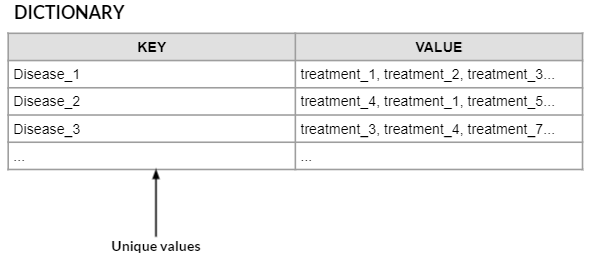

In [ ]:
id = 46
print("Sentence:",list_of_test_sent[id])
print("Orig Labels:", Y_test[id])
print("Pred Labels:", Y_pred[id])

In [ ]:
def update_list(list_disease,list_treatment,label_,word_):
   updated = 0
   if(label_ =='D' and len(word_)>1):
      list_disease.append(word_.lower())
      updated =1
   elif(label_ =='T'and len(word_)>1):
       list_treatment.append(word_.lower())
       updated =1
   return updated

In [ ]:
dict = {}
print(list_of_test_sent[46])
for pos in range(0,len(list_of_test_sent)):
    sentence = list_of_test_sent[pos]
    sentence_list = sentence.split()
    #print(sentence)
    tmpword = ''
    p_lbl =''
    list_treatment =[]  
    list_disease =[]
    for y in range(0,len(Y_pred[pos])):
        c_lbl = Y_pred[pos][y]
        if Y_pred[pos][y]=='T' or Y_pred[pos][y]=='D':
            tmpword = tmpword + " "+sentence_list[y]
            
        if(c_lbl != p_lbl):
            transit = update_list(list_disease,list_treatment,p_lbl,tmpword)
            if(transit):
              tmpword =""
        #print(list_treatment)
        p_lbl =c_lbl
    
    transit = update_list(list_disease,list_treatment,p_lbl,tmpword)
    if(transit):
        tmpword =""
    #store it in dictonary
    #print(list_treatment)
    for disease in list_disease:
        #treatments =",".join(list_treatment)
        treatments =listToString(list_treatment)
        #print(pos,list_treatment)
        print (pos,disease,treatments)
        if(disease in dict):
            tmp = dict[disease]
            #print(pos ,tmp)
            tmp = tmp+"," +treatments
            tmp = tmp.strip()
            #if(len(tmp)>1):
            dict[disease] = tmp
            #print('#'+tmp)
        else:
           my_str = treatments.strip()
           #if(len(my_str)>1):
           dict[disease] = my_str
    #    dict =dict.update(disease)
#print(len(dict))
#print(dict)

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [ ]:
dict[' hereditary retinoblastoma']